In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# For LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import initializers, regularizers, constraints, optimizers, layers
#import gensim.models.keyedvectors as word2vec
#import gc


# For Naive Bayes SVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,confusion_matrix
from scipy import sparse

C:\Users\amcle\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def random(self, split): 
    """ Selects a random fraction amount from self dataframe specified by split
    Parameters
    ----------
    self : pandas dataframe
    split : fraction of dataframe to sample
    Results
    ---------
    returns sampled dataframe
    """
    return self.sample(frac = split)

In [3]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Reads in both training and testing dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
print(train.shape, test.shape)
total_comments = train.shape[0] + test.shape[0]
print(total_comments)

(159571, 8) (153164, 2)
312735


In [5]:
x = train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums = train.iloc[:,2:].sum(axis=1)
train['clean'] = (rowsums == 0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ", len(train))
print("Total clean comments = ", train['clean'].sum())
print("Total tags =", x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [6]:
# Splitting the training set into 30% clean comments and non-clean comments to see the effects of class imbalancing
mdl_test = train.groupby(['clean'], group_keys = False).apply(random, 0.3)
mdl_train = train.loc[~train.index.isin(mdl_test.index)]

In [7]:
print(mdl_train.shape, mdl_test.shape)

(111699, 9) (47872, 9)


### Naive Bayes SVM

In [8]:
text = pd.concat([mdl_train['comment_text'],mdl_test['comment_text'], test['comment_text']]).reset_index(drop=True)

In [9]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'[a-z]{3,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_df = 50000,
    max_features=300)

tfidf.fit(text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=50000, max_features=300, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='[a-z]{3,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [10]:
# Gets the training and testing features 
x_train = tfidf.transform(mdl_train['comment_text'])
x_test = tfidf.transform(mdl_test['comment_text'])
y_train = mdl_train[classes]
y_test = mdl_test[classes]

In [11]:
def pr(y_i, y):
    p = x_train[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [12]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    
    # Cross Validation 3-Fold similar to Nikhit's implementation 
    logR = LogisticRegression(dual=True)
    m = GridSearchCV(estimator=logR, cv=3, param_grid={'C':[0.01,0.1,1,10]},scoring='roc_auc')
    
    x_nb = x_train.multiply(r)
    
    return m.fit(x_nb, y), r

CV Score for toxic = 0.894020044366872
CV Score for severe_toxic = 0.9685548020450678
CV Score for obscene = 0.938354971347464
CV Score for threat = 0.9310153976120362
CV Score for insult = 0.9160182598548634
CV Score for identity_hate = 0.9314060787198681


Text(0.5,1,'Naive Bayes SVM | Mean AUC = 0.92')

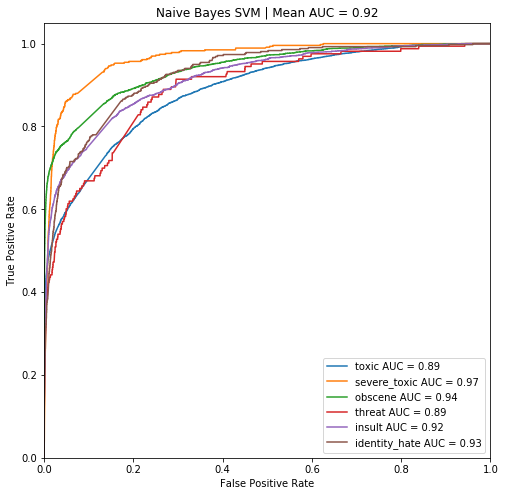

In [13]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    model,r = get_mdl(y_train[class_])
    print('CV Score for {} = {}'.format(class_, model.best_score_))
    prediction = model.predict_proba(x_test.multiply(r))
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Naive Bayes SVM | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))

In [14]:
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)

df_match = pd.DataFrame(match)

df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [15]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.84


### LSTM

In [16]:
Y = mdl_train[classes].values
train_sentences = mdl_train['comment_text']
test_sentences = mdl_test['comment_text']

In [17]:
embed_size = 128 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a comment to use

In [18]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_sentences))
tokenized_train = tokenizer.texts_to_sequences(train_sentences)
tokenized_test = tokenizer.texts_to_sequences(test_sentences)

In [19]:
# Max Length of the sentences is a paramter we can play with
X_t = pad_sequences(tokenized_train, maxlen=maxlen)
X_te = pad_sequences(tokenized_test, maxlen=maxlen)

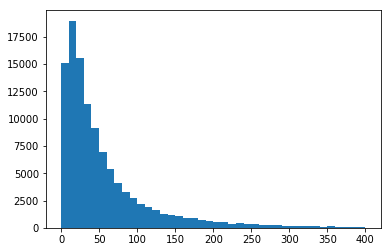

In [20]:
totalNumWords = [len(one_comment) for one_comment in tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

This is where we start to define the LSTM model used for this problem. 

In [21]:
def get_model():
    # Input Layer (shape is equal to the max length of features we defined before)
    inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

    # Defines the embedding layer which is basically a dimensionality reduction of the sentences into a defined feature space
    # Can also mess around with this parameter
    x = Embedding(max_features, embed_size)(inp)

    # Output size is another dimension we can mess around with in this case 60
    output_size = 60 #60
    x = LSTM(output_size, return_sequences=True, name='LSTM_Layer')(x)

    x = GlobalMaxPool1D()(x)

    # Dropout Layer
    percent_drop = 0.15 #.10
    x = Dropout(percent_drop)(x)

    # Dense Layer
    dense_size = 50
    x = Dense(dense_size, activation="relu")(x)

    # Dropout Layer 2
    x = Dropout(percent_drop)(x)

    # Dense Output Activation Layer
    x = Dense(6, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [22]:
model = get_model()
model.summary()

# Training the LSTM model
batch_size = 32
epochs = 2

# Fit the model
model.fit(X_t,Y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Predict 
y_pred = model.predict(X_te, batch_size = 1024)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

Text(0.5,1,'LSTM | Mean AUC = 0.98')

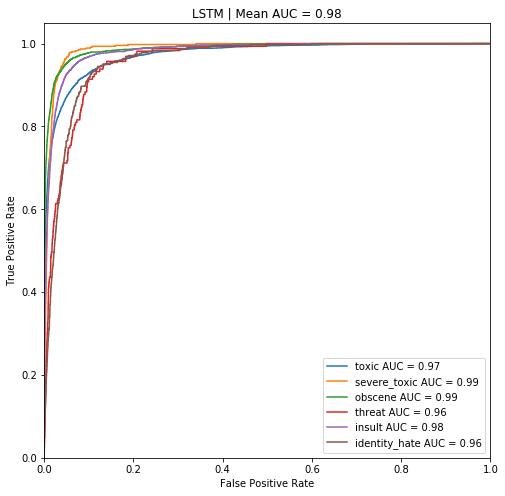

In [23]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for i,class_ in enumerate(classes):
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual, y_pred[:,i])
    d[class_] = d[class_] + np.where(y_pred[:,i] >= threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,y_pred[:,i]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
    
plt.title('LSTM | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))

In [24]:
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)

df_match = pd.DataFrame(match)

df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [25]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.92
